In [1]:
import sys
sys.path.append('./strats')
import pandas as pd
import numpy as np
from backtest_tool import load_plotly_theme
from backtest_tool import plot_strategy_and_benchmark
from backtest_tool import save_strategy_and_benchmark
from strats.strategy import strategy
from strats.rolling_mean_strat import Momentum_Rolling_Mean
from strats.rsi_ibs import RSI_IBS

load_plotly_theme()

In [2]:
bench = pd.read_csv("./data/BTCUSDT.csv", index_col=0)

In [3]:
bench['2017':'2018']

,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_volume,taker_buy_quote_volume
timestamp,,,,,,,,,,
2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009,2017-08-17 04:59:59.999,2.023661e+05,171,35.160503,1.509525e+05
2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916,2017-08-17 05:59:59.999,1.003048e+05,102,21.448071,9.260828e+04
2017-08-17 06:00:00,4330.29,4345.45,4309.37,4324.35,7.229691,2017-08-17 06:59:59.999,3.128231e+04,36,4.802861,2.079532e+04
2017-08-17 07:00:00,4316.62,4349.99,4287.41,4349.99,4.443249,2017-08-17 07:59:59.999,1.924106e+04,25,2.602292,1.129135e+04
2017-08-17 08:00:00,4333.32,4377.85,4333.32,4360.69,0.972807,2017-08-17 08:59:59.999,4.239504e+03,28,0.814655,3.552747e+03
...,...,...,...,...,...,...,...,...,...,...
2017-12-31 19:00:00,13745.00,13875.00,13700.00,13780.16,278.041542,2017-12-31 19:59:59.999000,3.832784e+06,3641,146.704521,2.022868e+06
2017-12-31 20:00:00,13783.09,14050.11,13780.13,13971.95,347.902334,2017-12-31 20:59:59.999000,4.850476e+06,4883,210.649864,2.937955e+06
2017-12-31 21:00:00,13971.95,14005.00,13900.01,13940.99,239.784462,2017-12-31 21:59:59.999000,3.341663e+06,3552,100.188897,1.397096e+06


In [4]:
bench['hourly_return_close'] = bench['close'].diff()
bench['hourly_return_close'] = bench['close'].pct_change(1)
bench['hourly_return_open'] = bench['open'].pct_change(1)


# Plot bench and interact with

We can plot the bench, candle style and interact with.

In [5]:
from tools import plot_asset_candle

plot_asset_candle(bench, 100)


# Let's try some indicators

## Horitontal lines

The function `plot_horizontal_supports_resistances` in the [graphical_indicators](./graphical_indicators.py) library allow us to print horizontales lines from an asset.

we can change the treshold between two consecutives lines to avoid having lines too close together

In [6]:
from graphical_indicators import plot_horizontal_supports_resistances

plot_horizontal_supports_resistances(bench.iloc[-250:])


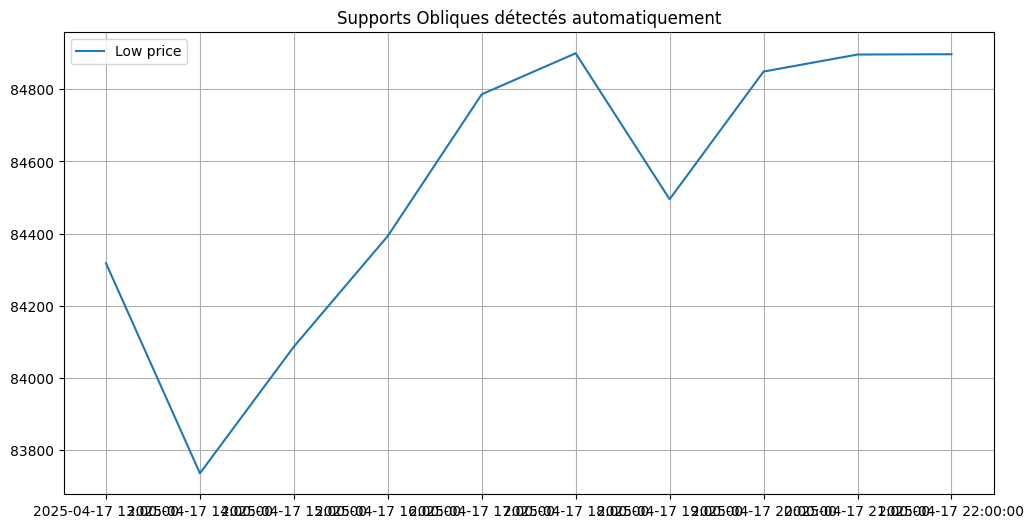

[]


In [7]:
import pandas as pd
import numpy as np
from scipy.signal import argrelextrema
import matplotlib.pyplot as plt
from itertools import combinations

def find_trendlines(df, order=5, tolerance=1e-2):
    lows_idx = argrelextrema(df['low'].values, np.less_equal, order=order)[0]
    lows = df.iloc[lows_idx][['low']]

    valid_trendlines = []

    for i, j, k in combinations(lows.index, 3):
        x = np.array([df.index.get_loc(i), df.index.get_loc(k)])  # positions numériques
        y = np.array([df['low'].loc[i], df['low'].loc[k]])


        # Droite entre i et k
        coeffs = np.polyfit(x, y, 1)  # y = mx + b
        line = np.poly1d(coeffs)

        # Vérifie que le point j est bien proche de la ligne (tolérance)
        j_pos = df.index.get_loc(j)
        if abs(df['low'][j] - line(j_pos)) > tolerance:

            continue

        # Vérifie que les prix ne passent PAS sous la ligne entre i et k
        segment = df.iloc[i:k+1]
        for idx in segment.index:
            x_idx = df.index.get_loc(idx)
            if df['low'][idx] < line(x_idx):

                break
        else:
            valid_trendlines.append((i, j, k, coeffs))

    return valid_trendlines

# Exemple avec df ayant des colonnes 'open', 'high', 'low', 'close'

df = bench.iloc[-10:]
trendlines = find_trendlines(df)

plt.figure(figsize=(12, 6))
plt.plot(df['low'], label='Low price')

for i, j, k, coeffs in trendlines:
    x_vals = np.array([i, k])
    y_vals = np.poly1d(coeffs)(x_vals)
    plt.plot(x_vals, y_vals, '--', label=f'Trendline {i}-{j}-{k}')

plt.title("Supports Obliques détectés automatiquement")
plt.legend()
plt.grid()
plt.show()

print(trendlines)


In [8]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from scipy.signal import argrelextrema
from itertools import combinations

# price nigggg
np.random.seed(42)
prices = np.cumsum(np.random.randn(100)) + 100  # prix simulés

df = bench.copy()

# max_locaux
n = 5
max_idx = argrelextrema(df['close'].values, np.greater_equal, order=n)[0]
max_points = [(i, df['close'][i]) for i in max_idx]

# N most freqqq points
recent_max_points = sorted(max_points, key=lambda x: x[0], reverse=True)[:2000]


# Here we will checkkk if points are aligned with a  tol
def are_aligned(p1, p2, p3, tol=1.5):
    # Droite entre p1 et p3
    x1, y1 = p1
    x3, y3 = p3
    if x3 == x1:
        return False  # éviter div/0
    a = (y3 - y1) / (x3 - x1)
    b = y1 - a * x1
    # Vérifier l'écart du point 2
    x2, y2 = p2
    y2_est = a * x2 + b
    return abs(y2 - y2_est) <= tol

# Chercher les combinaisons alignées
lines = []
for combo in combinations(recent_max_points, 3):
    p1, p2, p3 = sorted(combo, key=lambda x: x[0])  # ordre temporel
    if are_aligned(p1, p2, p3):
        lines.append((p1, p3))  # draw betwenn firtst and last 
        print('ij')
        break  # firsrt match we stop

# Plot avec plotly
fig = go.Figure()
fig.add_trace(go.Scatter(y=df['close'], mode='lines', name='Prix'))

# Tracer la ligne de résistance
for (x1, y1), (x2, y2) in lines:
    fig.add_shape(
        type='line',
        x0=x1, y0=y1,
        x1=x2, y1=y2,
        line=dict(color='red', width=2, dash='dash'),
    )
    fig.add_annotation(x=x2, y=y2, text="Résistance", showarrow=True, arrowhead=2, font=dict(color="red"))

# Affichage
fig.update_layout(title="Ligne de Résistance (3 points alignés)", xaxis_title="Index", yaxis_title="Prix")
fig.show()


ij


/tmp/ipykernel_7715/2591020810.py:16: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [9]:
bench

,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_volume,taker_buy_quote_volume,hourly_return_close,hourly_return_open
timestamp,,,,,,,,,,,,
2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009,2017-08-17 04:59:59.999,2.023661e+05,171,35.160503,1.509525e+05,NaN,NaN
2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916,2017-08-17 05:59:59.999,1.003048e+05,102,21.448071,9.260828e+04,0.001506,0.011111
2017-08-17 06:00:00,4330.29,4345.45,4309.37,4324.35,7.229691,2017-08-17 06:59:59.999,3.128231e+04,36,4.802861,2.079532e+04,0.002093,0.004980
2017-08-17 07:00:00,4316.62,4349.99,4287.41,4349.99,4.443249,2017-08-17 07:59:59.999,1.924106e+04,25,2.602292,1.129135e+04,0.005929,-0.003157
2017-08-17 08:00:00,4333.32,4377.85,4333.32,4360.69,0.972807,2017-08-17 08:59:59.999,4.239504e+03,28,0.814655,3.552747e+03,0.002460,0.003869
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-17 18:00:00,85108.67,85470.01,84899.71,84899.71,929.239650,2025-04-17 18:59:59.999000,7.923648e+07,120912,396.726970,3.383137e+07,-0.002455,0.002057
2025-04-17 19:00:00,84899.71,85119.47,84495.38,84849.06,870.295450,2025-04-17 19:59:59.999000,7.379743e+07,127392,383.455540,3.251911e+07,-0.000597,-0.002455
2025-04-17 20:00:00,84849.05,85140.00,84849.05,85140.00,383.924320,2025-04-17 20:59:59.999000,3.263660e+07,64881,197.214140,1.676528e+07,0.003429,-0.000597


# Let's use the backtest

Let's import some strats. They are class located in the folder [strat](./strats/)

In [10]:
from strats.candlestick_patterns import candlestick_patterns
from strats.fibonacci_horizontale import fibonacci_horizontale
from strats.breakout_pattern import breakout_patterns
from strats.reversal_pattern import reversal_pattern
from strats.harmonic_pattern import harmonic_pattern
from strats.fair_value_gap import FairValueGap

In [13]:
from collections import defaultdict
from backtest_tool import compute_sharpe
#from backtest_tool import backtest_from_strat

trading_fees = 0.001
#strat_arr = [Momentum_Rolling_Mean(), RSI_IBS()]
strat_arr = [Momentum_Rolling_Mean(), RSI_IBS()]
#strat_arr.append( candlestick_patterns())
#strat_arr.append(fibonacci_horizontale())
#strat_arr.append(breakout_patterns())
#strat_arr.append(reversal_pattern())
#strat_arr.append(harmonic_pattern())
strat_arr.append(FairValueGap())
params_strat = {
        'momentum_rolling_mean' : {},
        'RSI' : {'rsi_period' : 40}

}

params_strat = defaultdict(dict, params_strat)

rah = []
rih= []


def backtest_from_strat(strat_obj, bench, start=None, end=None, params={}, bench_target='hourly_return_open', plot_enable=True, sharp_treshold=0.99, vol_treshold=0.33,
                        return_treshold = 0.01, drawdown_treshold = -0.3, runup_treshold = 0.05,save_plot_enable=True, trading_fees = 0.001):
    """Backtest a strategy from the strategy class

    Args:
        strat_obj (_type_): _description_
        bench (_type_): _description_
        start (_type_, optional): _description_. Defaults to None.
        end (_type_, optional): _description_. Defaults to None.
        params (dict, optional): _description_. Defaults to {}.
        bench_target (str, optional): _description_. Defaults to 'hourly_return_open'.
        plot_enable (bool, optional): _description_. Defaults to True.
        sharp_treshold (float, optional): _description_. Defaults to 0.99.
        vol_treshold (float, optional): _description_. Defaults to 0.33.
        return_treshold (float, optional): _description_. Defaults to 0.01.
        drawdown_treshold (float, optional): _description_. Defaults to -0.3.
        save_plot_enable (bool, optional): _description_. Defaults to True.
        trading_fees (float, optional): _description_. Defaults to 0.001.
    """
    signal = strat_obj.compute_signal(bench, start=start, end=end, **params)
    signal = signal.fillna(0)
    strat = signal * bench[bench_target]
    strat -= (signal.diff().abs() * trading_fees)
    # Metrics calculus
    sharpe = compute_sharpe(strat)
    annualized_returns = (strat.mean() * 365 * 24)
    annualized_vol = (strat.std() * np.sqrt(365 * 24))
    drawdown = strat - strat.cummax()
    max_drawdown = drawdown.min()
    runup = strat - strat.cummin()
    max_runup = runup.max()


    nbr_position = (signal != 0).sum()
    win_position = (strat  > 0).sum()
    loss_position = (strat < 0).sum()
    flat_position = (strat == 0).sum()
    global rah
    global rih
    rah = signal
    rih = strat
    print(f'== \033[96m{strat_obj.name} \033[0m==\n')
    strat_obj.describe()
    print('let\'s print some metrics\n')
    print(f"number of non flat positions: {nbr_position}")
    print(f"number of winning positions: {win_position}")
    print(f"number of loosing positions (including fees after returning flat): {loss_position}")
    print(f"number of flat positions: {flat_position}")
    print(f"Annualized Return: {"\033[92m" if annualized_returns > return_treshold else '\033[91m'} {annualized_returns:.2%}\033[0m")
    print(f"Annualized Volatility:{"\033[92m" if annualized_vol < vol_treshold else '\033[91m'} {annualized_vol:.2%}\033[0m")
    print(f"Sharpe Ratio: {"\033[92m" if sharpe > sharp_treshold else '\033[91m'} {sharpe:.2f}\033[0m")
    print(f"Max Drawdown: {"\033[92m" if max_drawdown > drawdown_treshold else '\033[91m'} {max_drawdown:.2%}\033[0m")
    print(f"Max Run-Up: {"\033[92m" if max_runup > runup_treshold else '\033[91m'} {max_runup:.2%}\033[0m\n\n")
    bench_to_plot = bench[bench_target]
    if start and end:
        bench_to_plot = bench_to_plot[start:end]
    elif start:
        bench_to_plot = bench_to_plot[start:]
    elif end:
        bench_to_plot = bench_to_plot[end:]
    if plot_enable:
        plot_strategy_and_benchmark(strat.cumsum(), bench_to_plot.cumsum(), title=strat_obj.name)
    start_str = 'lowest' if start is None else str(start)
    end_str = 'highest' if end is None else str(end)
    if save_plot_enable:
        save_strategy_and_benchmark(strat.cumsum(), bench_to_plot.cumsum(), title=f"{strat_obj.name}",save_path=f'./output/{strat_obj.name}_from_{start_str}_to_{end_str}.png')



for strat in strat_arr:
    backtest_from_strat(strat, bench, params=params_strat[strat.name],plot_enable=False, save_plot_enable=True, trading_fees=trading_fees)


== momentum_rolling_mean ==

Strategy name: momentum_rolling_mean
Asset Targeted: BTCUSDT

The principle of this strategy is simple
We have to windows on long and the other one short
We go long when the mean of the long window applied on the close is lower than the one from the short window
We are short on the opposite
There is no flat on this strategy


let's print some metrics

number of non flat positions: 67090
number of winning positions: 33056
number of loosing positions (including fees after returning flat): 34012
number of flat positions: 22
Annualized Return:  179.98%
Annualized Volatility: 75.88%
Sharpe Ratio:  2.37
Max Drawdown:  -35.59%
Max Run-Up:  34.32%


== RSI ==

Strategy name: RSI
Asset Targeted: BTCUSDT

This strategy identifies short-term reversal opportunities using two technical indicators: RSI and IBS.
A long position is opened when the RSI is below 30 (indicating oversold conditions) and the IBS is below 0.2 (close near the day's low),
while a short position is